In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
mm = pd.read_csv("mmALL_073120_csv.csv")
mm = mm.query('protest == 1')
mm = mm.reset_index()

In [3]:
mm.columns # country-region-location, year, start-end, violence, amt of protesters, protesteridentity, demands, responses

Index(['index', 'id', 'country', 'ccode', 'year', 'region', 'protest',
       'protestnumber', 'startday', 'startmonth', 'startyear', 'endday',
       'endmonth', 'endyear', 'protesterviolence', 'location',
       'participants_category', 'participants', 'protesteridentity',
       'protesterdemand1', 'protesterdemand2', 'protesterdemand3',
       'protesterdemand4', 'stateresponse1', 'stateresponse2',
       'stateresponse3', 'stateresponse4', 'stateresponse5', 'stateresponse6',
       'stateresponse7', 'sources', 'notes'],
      dtype='object')

# I. how does state response vary?

In [4]:
mm.stateresponse1.unique()

array(['ignore', 'accomodation', 'crowd dispersal', 'arrests',
       'shootings', 'beatings', 'killings', nan], dtype=object)

In [5]:
for r in mm.region.unique():
    re = r
    print(r+": ")
    print(mm.query("region == @re").country.unique())
    print("---")

North America: 
['Canada' 'Cuba' 'Haiti' 'Dominican Republic' 'Jamaica' 'Mexico']
---
Central America: 
['Guatemala' 'Honduras' 'El Salvador' 'Nicaragua' 'Costa Rica' 'Panama']
---
South America: 
['Colombia' 'Venezuela' 'Guyana' 'Suriname' 'Ecuador' 'Peru' 'Brazil'
 'Bolivia' 'Paraguay' 'Chile' 'Argentina' 'Uruguay']
---
Europe: 
['United Kingdom' 'Ireland' 'Netherlands' 'Belgium' 'Luxembourg' 'France'
 'Switzerland' 'Spain' 'Portugal' 'Germany' 'Germany West' 'Germany East'
 'Poland' 'Austria' 'Hungary' 'Czechoslovakia' 'Czech Republic'
 'Slovak Republic' 'Italy' 'Albania' 'Kosovo' 'Serbia' 'Macedonia'
 'Croatia' 'Yugoslavia' 'Bosnia' 'Serbia and Montenegro' 'Montenegro'
 'Slovenia' 'Greece' 'Cyprus' 'Bulgaria' 'Moldova' 'Romania' 'USSR'
 'Russia' 'Estonia' 'Latvia' 'Lithuania' 'Ukraine' 'Belarus' 'Armenia'
 'Georgia' 'Azerbaijan' 'Finland' 'Sweden' 'Norway' 'Denmark']
---
Africa: 
['Cape Verde' 'Guinea-Bissau' 'Equatorial Guinea' 'Gambia' 'Mali'
 'Senegal' 'Benin' 'Mauritania' 'Nige

In [6]:
def quantify_stateresponse(col):
    nums = []
    response_dict = {"accomodation":3, "crowd dispersal":-1,"arrests":-2,"beatings":-3,"shootings":-4,"killings":-5,"ignore":0}
    for r in col:
        if r in response_dict: nums.append(response_dict[r])
        else: nums.append(0)
    return nums

In [7]:
quantified = mm[["stateresponse1","stateresponse2","stateresponse3","stateresponse4","stateresponse5","stateresponse6","stateresponse7"]]
quantified = quantified.apply(quantify_stateresponse)
mm["stateresponse_sum"] = quantified.sum(axis=1)

## a. does it correlate with location?

In [8]:
mm.region.unique()

array(['North America', 'Central America', 'South America', 'Europe',
       'Africa', 'MENA', 'Asia', 'Oceania'], dtype=object)

In [9]:
len(mm.country.unique())

166

In [10]:
mm.region = [x.replace(" ", '\n') for x in mm.region.to_list()]
# mm.country = [x.replace(" ", '\n') for x in mm.country.to_list()]

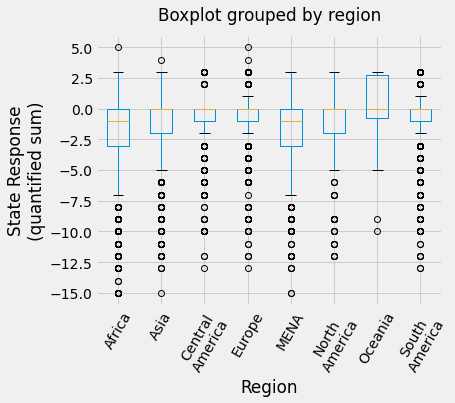

In [11]:
mm.boxplot(by = 'region', column = 'stateresponse_sum', figsize = [6,5], rot = 60)
plt.xlabel('Region')
plt.ylabel('State Response\n(quantified sum)')
plt.title('')
plt.savefig("stateresponse_region", dpi=400, bbox_inches = 'tight')

In [12]:
top_countries = pd.DataFrame(mm.country.value_counts()).reset_index()
top_countries = top_countries.rename(columns = {'country':'count','index':'country'}).query('count > 200')
# len(top_countries.query('count > 150'))

In [13]:
mm_topcountries = mm[mm['country'].isin(top_countries.country)]

# cr_means = {} #cr for country_response
# for c in mm.country.unique():
#     co = c
#     cr_means[co] = cr_means.get(co, mm.query('country == @co').stateresponse_sum.mean())
    
# mean_countryresponse = []
# for i in mm_topcountries.index:
#     mean_countryresponse.append(cr_means[mm_topcountries.country[i]])
# mm_topcountries['mean_countryresponse'] = mean_countryresponse

In [14]:
# mm_topcountries.sort_values('mean_countryresponse').country.unique()
# mm_topcountries = mm_topcountries.sort_values('mean_countryresponse')

In [15]:
# stateresponse_demand.protesterdemand = [x.replace("labor wage dispute", 'labor wage\ndispute') for x in stateresponse_demand.protesterdemand.to_list()]
# mm_topcountries.country = [x.replace("United Kingdom", 'UK') for x in mm_topcountries.country.to_list()]
# mm_topcountries.country = [x.replace("South Korea", 'S Korea') for x in mm_topcountries.country.to_list()]

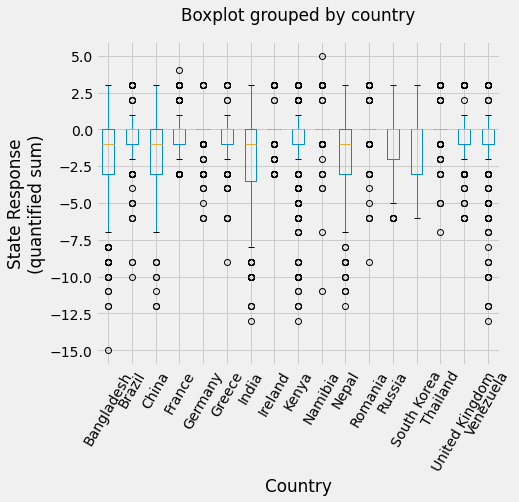

In [16]:
mm_topcountries.boxplot(by = 'country', column = 'stateresponse_sum', figsize = [7,6], rot = 60)
plt.xlabel('Country')
plt.ylabel('State Response\n(quantified sum)')
plt.title('')

plt.savefig("stateresponse_country", dpi=400, bbox_inches = 'tight')

### i. country w/ personal freedom index

In [17]:
freedom = pd.read_csv('countryfreedom.csv')
mm_freedom = pd.merge(mm_topcountries, freedom, on = 'country', how = 'left')
mm_freedom = mm_freedom[['country','region','stateresponse_sum','country','persFreedom']]

In [18]:
freedom.columns

Index(['country', 'humanFreedom', 'hfRank', 'persFreedom', 'econFreedom',
       'quartile'],
      dtype='object')

In [19]:
mm_freedom.persFreedom.unique()

array([4.9 , 7.64, 9.19, 9.4 , 8.91, 9.32, 8.37, 8.65, 5.9 , 6.59, 8.12,
       4.87, 8.94, 6.2 , 5.52, 7.41, 6.9 ])

In [20]:
mm_freedom.query('persFreedom == 7.64').quantile(.1).stateresponse_sum

-2.6999999999999993

In [21]:
freeminy = []
freeminx = []
for v in mm_freedom.persFreedom.unique():
    va = v
    freeminx.append(va)
    freeminy.append(mm_freedom.query('persFreedom == @va').quantile(.0001).stateresponse_sum)

In [22]:
# freex = np.array(mm_freedom.persFreedom).reshape(-1,1)
# freey = np.array(mm_freedom.stateresponse_sum).reshape(-1,1)
# modelfree = LinearRegression().fit(freex, freey)
# mfree = modelfree.coef_[0][0]
# bfree = modelfree.intercept_[0]
# modelfree.score(freex, freey), mfree, bfree

freex = np.array(freeminx).reshape(-1,1)
freey = np.array(freeminy).reshape(-1,1)
modelfree = LinearRegression().fit(freex, freey)
mfree = modelfree.coef_[0][0]
bfree = modelfree.intercept_[0]
modelfree.score(freex, freey), mfree, bfree

(0.5174932461489969, 1.6885896014275295, -21.62527171465021)

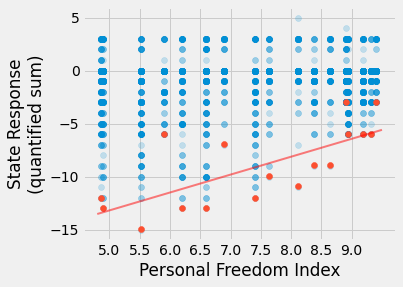

In [126]:
plt.figure(figsize = [5,4])
plt.scatter(mm_freedom.persFreedom, mm_freedom.stateresponse_sum, alpha = .2)
plt.scatter(freeminx, freeminy)
freelims = np.array([4.8,9.5])
plt.xticks(np.arange(5,9.5,.5))
plt.plot(freelims, freelims*mfree + bfree,alpha = 0.5, c = 'red', lw = 2)
plt.xlabel('Personal Freedom Index')
plt.ylabel('State Response\n(quantified sum)')
plt.savefig("freedom", dpi=400, bbox_inches = 'tight')

## b. by duration?

In [24]:
start = mm[['startyear', 'startmonth', 'startday']]
start = start.rename(columns = {'startyear':'year','startmonth':'month','startday':'day'})
mm['start'] = pd.to_datetime(start,yearfirst = True)

end = mm[['endyear', 'endmonth', 'endday']]
end = end.rename(columns = {'endyear':'year','endmonth':'month','endday':'day'})
mm['end'] = pd.to_datetime(end,yearfirst = True)

mm['duration'] = (mm.end - mm.start).dt.days

In [25]:
mm.duration.quantile(.999)

175.3340000000171

In [26]:
mm_regduration = mm.query('duration <= 100')
mm_longduration = mm.query('duration > 100')

In [27]:
yval = mm_regduration.query('stateresponse_sum == -10')
g = yval.query('duration > 20')
g.duration

10463    51
11081    53
13482    21
13534    43
15235    25
Name: duration, dtype: int64

In [28]:
duration_response99x_all, duration_response99y_all = [], []
duration_response99x, duration_response99y = [], []
for s in mm_regduration.stateresponse_sum.unique():
    ss = s
    yval = mm_regduration.query('stateresponse_sum == @ss')
    q99 = yval.duration.quantile(.9999)
    duration_response99y.append(ss)
    duration_response99x.append(q99)
    duration_response99y_all.append(ss)
    duration_response99x_all.append(q99)
    for g in yval.query('duration > @q99').duration:
        duration_response99y_all.append(ss)
        duration_response99x_all.append(g)

linreg99x = np.array(duration_response99x).reshape(-1,1)
linreg99y = np.array(duration_response99y).reshape(-1,1)
model99 = LinearRegression().fit(linreg99x, linreg99y)
m = model99.coef_[0][0]
b = model99.intercept_[0]
model99.score(linreg99x, linreg99y), m, b

(0.16447157436606408, 0.07648213084093987, -9.135182677016942)

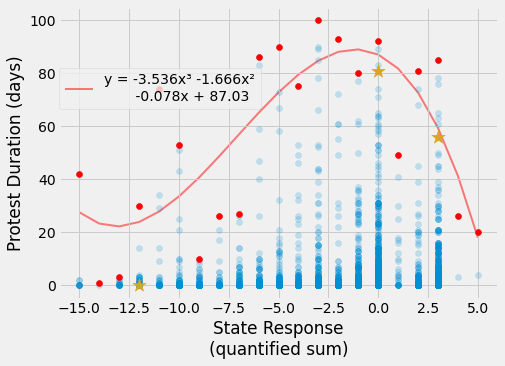

In [133]:
durmaxx = []
durmaxy = []
for v in mm_regduration.stateresponse_sum.unique():
    va = v
    durmaxx.append(va)
    durmaxy.append(mm_regduration.query('stateresponse_sum == @va').duration.max())
durmax = pd.DataFrame(durmaxx,durmaxy).reset_index()
durmax.columns = ['x','y']
durmax = durmax.sort_values('y')
durmaxx = np.array(durmax.y)
durmaxy = np.array(durmax.x)

plt.figure(figsize = [7,5])
plt.scatter(mm_regduration.stateresponse_sum, mm_regduration.duration, alpha = .2)

poly = PolynomialFeatures(degree = 3, include_bias=False)
poly_features = poly.fit_transform(durmaxx.reshape(-1,1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, durmaxy.reshape(-1,1))
y_predicted= poly_reg_model.predict(poly_features)
 
plt.plot(durmaxx, y_predicted, zorder = 0, color='red',alpha = .5, lw = 2, label = 'y = -3.536x\u00b3 -1.666x\u00b2\n       -0.078x + 87.03') 
plt.scatter(durmaxx,durmaxy, color = 'red', zorder = 1)

plt.scatter([-12,0,3],[0,81,56], c = 'goldenrod', s=200, marker="*")

plt.legend(loc = (0,.65))
plt.ylabel("Protest Duration (days)")
plt.xlabel("State Response\n(quantified sum)")
plt.savefig("duration_response_poly", dpi=400, bbox_inches = 'tight')

In [30]:
reg_label = "Inliers coef:%s - b:%0.2f" % \
            (np.array2string(poly_reg_model.coef_,
                             formatter={'float_kind': lambda fk: "%.3f" % fk}),
            poly_reg_model.intercept_)
print(reg_label)

Inliers coef:[[-3.536 -1.666 -0.078]] - b:87.03


In [31]:
from sklearn.metrics import r2_score
r2_score(durmaxy, y_predicted)

0.5886559578215251

## c. by protester demand?

In [32]:
mm.columns

Index(['index', 'id', 'country', 'ccode', 'year', 'region', 'protest',
       'protestnumber', 'startday', 'startmonth', 'startyear', 'endday',
       'endmonth', 'endyear', 'protesterviolence', 'location',
       'participants_category', 'participants', 'protesteridentity',
       'protesterdemand1', 'protesterdemand2', 'protesterdemand3',
       'protesterdemand4', 'stateresponse1', 'stateresponse2',
       'stateresponse3', 'stateresponse4', 'stateresponse5', 'stateresponse6',
       'stateresponse7', 'sources', 'notes', 'stateresponse_sum', 'start',
       'end', 'duration'],
      dtype='object')

In [33]:
stateresponse_demand1 = mm[['protesterdemand1','stateresponse_sum', 'protesterviolence', 'startyear', 'start']]
# stateresponse_demand1.protesterdemand1 = [str(x).replace(", ",",\n") for x in stateresponse_demand1.protesterdemand1.to_list()]
stateresponse_demand1 = stateresponse_demand1.rename(columns = {'protesterdemand1' : 'protesterdemand'})

stateresponse_demand2 = mm[['protesterdemand2','stateresponse_sum', 'protesterviolence','startyear', 'start']]
# stateresponse_demand2.protesterdemand2 = [str(x).replace(", ",",\n") for x in stateresponse_demand2.protesterdemand2.to_list()]
stateresponse_demand2 = stateresponse_demand2.rename(columns = {'protesterdemand2' : 'protesterdemand'})

stateresponse_demand3 = mm[['protesterdemand3','stateresponse_sum', 'protesterviolence','startyear', 'start']]
# stateresponse_demand3.protesterdemand3 = [str(x).replace(", ",",\n") for x in stateresponse_demand3.protesterdemand3.to_list()]
stateresponse_demand3 = stateresponse_demand3.rename(columns = {'protesterdemand3' : 'protesterdemand'})

stateresponse_demand4 = mm[['protesterdemand4','stateresponse_sum', 'protesterviolence','startyear', 'start']]
# stateresponse_demand4.protesterdemand4 = [str(x).replace(", ",",\n") for x in stateresponse_demand4.protesterdemand4.to_list()]
stateresponse_demand4 = stateresponse_demand4.rename(columns = {'protesterdemand4' : 'protesterdemand'})

stateresponse_demand = pd.concat([stateresponse_demand1, stateresponse_demand2, stateresponse_demand3, stateresponse_demand4])
# stateresponse_demand = stateresponse_demand.protesterdemand.fillna('.')

stateresponse_demand = stateresponse_demand.query('protesterdemand != "."')
stateresponse_demand = stateresponse_demand.query('protesterdemand != "nan"')

# sd_q25 = stateresponse_demand.quantile(.05).stateresponse_sum
# sd_q75 = stateresponse_demand.quantile(.95).stateresponse_sum
# stateresponse_demand_iqr = stateresponse_demand.query('stateresponse_sum >= @sd_q25')
# stateresponse_demand_iqr = stateresponse_demand_iqr.query('stateresponse_sum <= @sd_q75')

# sd_q25, sd_q75

In [34]:
type(stateresponse_demand.protesterdemand.to_list()[0])

str

In [35]:
# stateresponse_demand.protesterdemand = [x.replace("labor wage dispute", 'labor wage\ndispute') for x in stateresponse_demand.protesterdemand.to_list()]
# stateresponse_demand.protesterdemand = [x.replace("land farm issue", 'land farm\nissue') for x in stateresponse_demand.protesterdemand.to_list()]
# stateresponse_demand.protesterdemand = [x.replace("removal of politician", 'removal of\npolitician') for x in stateresponse_demand.protesterdemand.to_list()]
# stateresponse_demand.protesterdemand = [x.replace("political behavior, process", 'governance') for x in stateresponse_demand.protesterdemand.to_list()]
# # stateresponse_demand.protesterdemand = [x.replace("social restrictions", 'social\nrestrictions') for x in stateresponse_demand.protesterdemand.to_list()]
# stateresponse_demand.protesterdemand = [x.replace("price, tax policy", 'price, tax') for x in stateresponse_demand.protesterdemand.to_list()]
# stateresponse_demand.protesterdemand = [x.replace("police brutality", 'police\nbrutality') for x in stateresponse_demand.protesterdemand.to_list()]

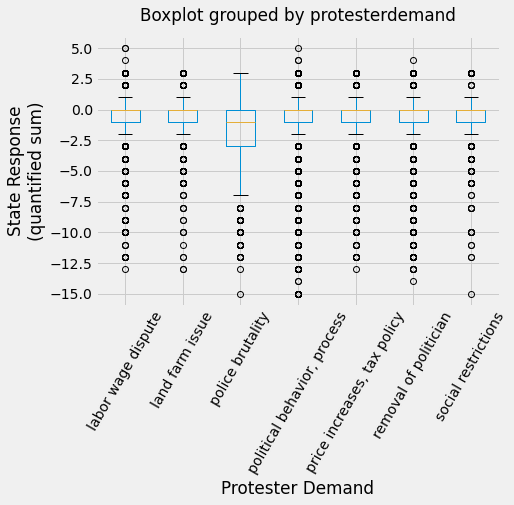

In [36]:
stateresponse_demand.boxplot(by = 'protesterdemand', column = 'stateresponse_sum', figsize = [7,5], rot = 60)
plt.title('')
plt.xlabel('Protester Demand')
plt.ylabel('State Response\n(quantified sum)')
plt.savefig("stateresponse_demand", dpi=400, bbox_inches = 'tight')

# II. demands across the years

In [37]:
demands = stateresponse_demand.protesterdemand # did this bc stateresponse_demand had the concat'ed demands

In [38]:
d = pd.DataFrame(demands.value_counts())
d['percents'] = d.protesterdemand / len(demands)
d

,protesterdemand,percents
"political behavior, process",10750,0.178536
labor wage dispute,2211,0.036720
removal of politician,1891,0.031406
"price increases, tax policy",1414,0.023484
police brutality,1101,0.018285
social restrictions,684,0.011360
land farm issue,582,0.009666


In [39]:
# plt.figure(figsize = [10,5])
# plt.bar(d.index, d.percents)

In [40]:
demands_year = pd.DataFrame()
for y in mm.startyear.unique():
    year = y
    yeardemands = stateresponse_demand.query('startyear == @year').protesterdemand
    yd = pd.DataFrame(yeardemands.value_counts())
    yd['percents'] = yd.protesterdemand / len(mm)
    yd['year'] = [y]*len(yd)
    demands_year = pd.concat([demands_year, yd])
demands_year = demands_year.reset_index()
demands_year = demands_year.rename(columns = {'index':'demand'})
demands_year = demands_year.sort_values('year')
# demands_year = demands_year.query('year >= 2000')
demands_year.year = demands_year.year.apply(int)

In [41]:
demands_year["demand"] = [x.replace("political behavior, process", 'governance') for x in demands_year['demand'].to_list()]
demands_year["demand"] = [x.replace("price increases, tax policy", 'price, tax') for x in demands_year['demand'].to_list()]

In [42]:
# total = pd.DataFrame(mm.startyear.value_counts())
# total = total.reset_index()
# total = total.rename(columns = {'index':'year','startyear':'c'})
# total.year = total.year.apply(int)
# total = total.sort_values('year')

# len(total.year), len(total.c)

In [44]:
governance = demands_year.query('demand == "governance"')
behead = demands_year.query('demand == "removal of politician"')
price = demands_year.query('demand == "price, tax"')
wage = demands_year.query('demand == "labor wage dispute"')
police = demands_year.query('demand == "police brutality"')
social = demands_year.query('demand == "social restrictions"')
land = demands_year.query('demand == "land farm issue"')

In [45]:
demands_year.query('year == 2019')

,demand,protesterdemand,percents,year
155,removal of politician,324,0.021261,2019
156,police brutality,102,0.006693,2019
157,labor wage dispute,69,0.004528,2019
158,social restrictions,58,0.003806,2019
159,"price, tax",54,0.003544,2019
160,land farm issue,23,0.001509,2019
154,governance,622,0.040816,2019


In [46]:
total = pd.DataFrame()
total['year'] = mm.sort_values('year').year.unique()
tc = []
for y in total.year:
    ye = y
    tc.append(demands_year.query('year == @ye').protesterdemand.sum())
total['tc'] = tc

In [47]:
totalprotests = pd.DataFrame()
totalprotests['year'] = mm.sort_values('year').year.unique()
c = []
for y in totalprotests.year:
    ye = y
    c.append(len(mm.query('year == @ye')))
totalprotests['c'] = c
totalprotests.head()

,year,c
0,1990,572
1,1991,372
2,1992,409
3,1993,329
4,1994,390


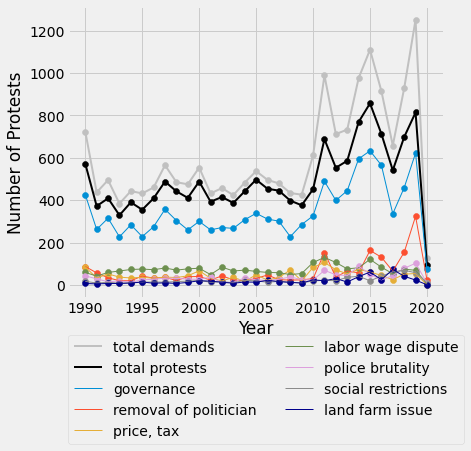

In [48]:
plt.figure(figsize = [6,5])

plt.scatter(total.year, total.tc, c = 'silver')
plt.plot(total.year, total.tc, label = 'total demands', c = 'silver', lw = 2)
plt.scatter(totalprotests.year, totalprotests.c, c = 'black')
plt.plot(totalprotests.year, totalprotests.c, c = 'black', lw = 2, label = 'total protests')

plt.scatter(governance.year, governance.protesterdemand)
plt.scatter(behead.year, behead.protesterdemand)
plt.scatter(price.year, price.protesterdemand)
plt.scatter(wage.year, wage.protesterdemand)
plt.scatter(police.year, police.protesterdemand, c = 'plum')
plt.scatter(social.year, social.protesterdemand)
plt.scatter(land.year, land.protesterdemand, c = 'darkblue')
plt.plot(governance.year, governance.protesterdemand, lw = 1, label = 'governance')
plt.plot(behead.year, behead.protesterdemand, lw = 1, label = 'removal of politician')
plt.plot(price.year, price.protesterdemand, lw = 1, label = 'price, tax')
plt.plot(wage.year, wage.protesterdemand, lw = 1, label = 'labor wage dispute')
plt.plot(police.year, police.protesterdemand, lw = 1, label = 'police brutality', c = 'plum')
plt.plot(social.year, social.protesterdemand, lw = 1, label = 'social restrictions')
plt.plot(land.year, land.protesterdemand, lw = 1, c = 'darkblue', label = 'land farm issue')

plt.legend(ncol = 2, loc = (0, -.5))
plt.xticks(np.arange(1990,2021,5))

plt.xlabel('Year')
plt.ylabel('Number of Protests')

plt.savefig("demand_year", dpi=400, bbox_inches = 'tight')

In [49]:
mm.query('startyear < 1994')[['participants','country','year','protesterdemand1','protesteridentity','notes']].head(100)#.query('participants == "1 million"')

,participants,country,year,protesterdemand1,protesteridentity,notes
0,1000s,Canada,1990,"political behavior, process",unspecified,canada s railway passenger system was finally ...
1,1000,Canada,1990,"political behavior, process",unspecified,protestors were only identified as young peopl...
2,500,Canada,1990,"political behavior, process",separatist parti quebecois,"the queen, after calling on canadians to remai..."
3,100s,Canada,1990,land farm issue,mohawk indians,canada s federal government has agreed to acqu...
4,950,Canada,1990,"political behavior, process",local residents,protests were directed against the state due t...
...,...,...,...,...,...,...
982,14000,Colombia,1990,"political behavior, process",banana workers,general strike
983,10000,Colombia,1990,"price increases, tax policy",workers,general strike and demonstration
984,200000,Colombia,1991,police brutality,teachers,general strike
985,30000,Colombia,1991,"political behavior, process",farm workers,blocking roads


In [103]:
mm.participants_category.unique()
# mm[['participants', 'participants_category']].sort_values('participants_category')

array([nan, '50-99', '100-999', '2000-4999', '1000-1999', '5000-10000',
       '>10000'], dtype=object)

In [131]:
export = mm_regduration.query('duration == 0').query('stateresponse_sum == -12').query('country == "South Africa"')#\
[['duration','country','participants_category',\
  'stateresponse_sum','stateresponse1', 'stateresponse2','stateresponse3', 'stateresponse4', 'stateresponse5', 'stateresponse6',\
  'startyear','notes']]
len(export)
export

,index,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,...,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes,stateresponse_sum,start,end,duration
10080,11226,5601991009,South Africa,560,1991,Africa,1,9,1.0,6.0,...,crowd dispersal,NaN,NaN,NaN,5 are killed in south africa in protest and bl...,five people were killed overnight in 30 incide...,-12,1991-06-01,1991-06-01,0
10082,11228,5601991011,South Africa,560,1991,Africa,1,11,10.0,8.0,...,arrests,NaN,NaN,NaN,2 killed as apartheid supporters battle police...,hundreds of policemen and white protesters bat...,-12,1991-08-10,1991-08-10,0


In [117]:
import os
export.to_csv('midaccommodate.csv')